In [2]:
!pip install -q kaggle
!pip install -q scikit-image tqdm
!pip install -q scikit-image tqdm tensorflow


In [3]:
# Requirements
import json
import os, glob
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import io
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:


# Remplace par tes identifiants
kaggle_username = "..."
kaggle_key = "..."

# Créer le dossier ~/.kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Créer le fichier kaggle.json
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

# Modifier les permissions
!chmod 600 /root/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d andrewmvd/pediatric-pneumonia-chest-xray


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 1.12G/1.14G [00:08<00:00, 37.0MB/s]
100% 1.14G/1.14G [00:08<00:00, 150MB/s] 


In [6]:
zip_path = "/content/pediatric-pneumonia-chest-xray.zip"
extract_path = "/content/pediatric-pneumonia-chest-xray"

if not os.path.exists(extract_path):
    !unzip -q /content/pediatric-pneumonia-chest-xray.zip -d /content/
    print("Dataset unzipped successfully!")
else:
    print("Dataset already extracted.")

# 🔍 Check extracted folders
print(os.listdir("/content/Pediatric Chest X-ray Pneumonia"))

Dataset unzipped successfully!
['test', 'train']


In [7]:

print(os.listdir("/content"))  # devrait afficher ['Normal', 'TB']
print("Normal images / train:", len(os.listdir("/content/Pediatric Chest X-ray Pneumonia/train/NORMAL")))
print("Pneumonia images / train:", len(os.listdir("/content/Pediatric Chest X-ray Pneumonia/train/PNEUMONIA")))
print("Normal images / test:", len(os.listdir("/content/Pediatric Chest X-ray Pneumonia/test/NORMAL")))
print("Pneumonia images / test:", len(os.listdir("/content/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA")))

['.config', 'pediatric-pneumonia-chest-xray.zip', 'Pediatric Chest X-ray Pneumonia', 'sample_data']
Normal images / train: 1349
Pneumonia images / train: 3883
Normal images / test: 234
Pneumonia images / test: 390


In [8]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# ANALYSE (résolution, distribution, qualité des annotations)

In [9]:
import os, glob
from skimage import io
import pandas as pd
from tqdm import tqdm

DATASET_PATH = "/content/Pediatric Chest X-ray Pneumonia/"
CLASSES = ["NORMAL", "PNEUMONIA"]  # Your classes

records = []
for split in ["train", "test"]:
    for cls in CLASSES:
        folder = os.path.join(DATASET_PATH, split, cls)
        files = sorted(glob.glob(os.path.join(folder, "*")))

        for f in tqdm(files, desc=f"Scanning {split}/{cls}"):
            try:
                img = io.imread(f)
                h, w = img.shape[:2]
                fmt = os.path.splitext(f)[1].lower()
                records.append({
                    "path": f,
                    "class": cls,
                    "split": split,
                    "height": h,
                    "width": w,
                    "channels": img.ndim,
                    "format": fmt,
                    "ok": True
                })
            except Exception as e:
                records.append({
                    "path": f,
                    "class": cls,
                    "split": split,
                    "height": None,
                    "width": None,
                    "channels": None,
                    "format": None,
                    "ok": False,
                    "error": str(e)
                })

df = pd.DataFrame(records)

# 📊 Summary
print("Class distribution:")
print(df.groupby(["split", "class"]).size())

print("\nImage size statistics:")
print(df[["height", "width"]].describe())

# 🛑 Check for corrupted files
bad = df[df["ok"] == False]
if len(bad) > 0:
    print("\nCorrupted or unreadable images:")
    print(bad[["path", "error"]])
else:
    print("\nNo corrupted images detected!")

# 🔍 Check duplicates by filename
dupes = df['path'].apply(os.path.basename).value_counts()
dupes = dupes[dupes > 1]
if len(dupes) > 0:
    print("\nDuplicate filenames detected:")
    print(dupes)
else:
    print("\nNo duplicate filenames found.")


Scanning test/PNEUMONIA: 100%|██████████| 390/390 [00:01<00:00, 245.91it/s]


Class distribution:
split  class    
test   NORMAL        234
       PNEUMONIA     390
train  NORMAL       1349
       PNEUMONIA    3883
dtype: int64

Image size statistics:
            height        width
count  5856.000000  5856.000000
mean    970.689037  1327.880806
std     383.392117   363.500922
min     127.000000   384.000000
25%     688.000000  1056.000000
50%     888.000000  1281.000000
75%    1187.000000  1560.000000
max    2713.000000  2916.000000

No corrupted images detected!

No duplicate filenames found.


In [11]:
df

,path,class,split,height,width,channels,format,ok
0,/content/Pediatric Chest X-ray Pneumonia/train...,NORMAL,train,1858,2090,2,.jpeg,True
1,/content/Pediatric Chest X-ray Pneumonia/train...,NORMAL,train,1152,1422,2,.jpeg,True
2,/content/Pediatric Chest X-ray Pneumonia/train...,NORMAL,train,1434,1810,2,.jpeg,True
3,/content/Pediatric Chest X-ray Pneumonia/train...,NORMAL,train,1279,1618,2,.jpeg,True
4,/content/Pediatric Chest X-ray Pneumonia/train...,NORMAL,train,1125,1600,2,.jpeg,True
...,...,...,...,...,...,...,...,...
5851,/content/Pediatric Chest X-ray Pneumonia/test/...,PNEUMONIA,test,856,1120,2,.jpeg,True
5852,/content/Pediatric Chest X-ray Pneumonia/test/...,PNEUMONIA,test,856,1064,2,.jpeg,True
5853,/content/Pediatric Chest X-ray Pneumonia/test/...,PNEUMONIA,test,1024,1400,2,.jpeg,True
5854,/content/Pediatric Chest X-ray Pneumonia/test/...,PNEUMONIA,test,1016,1264,2,.jpeg,True


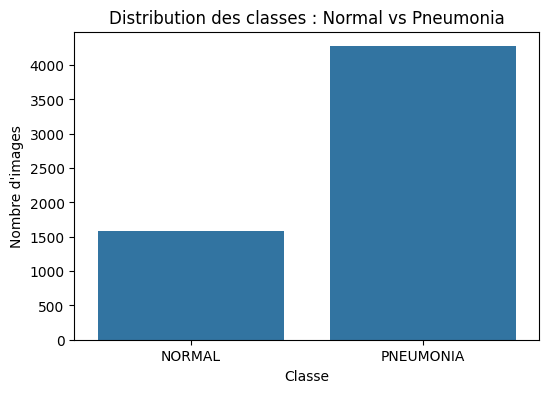

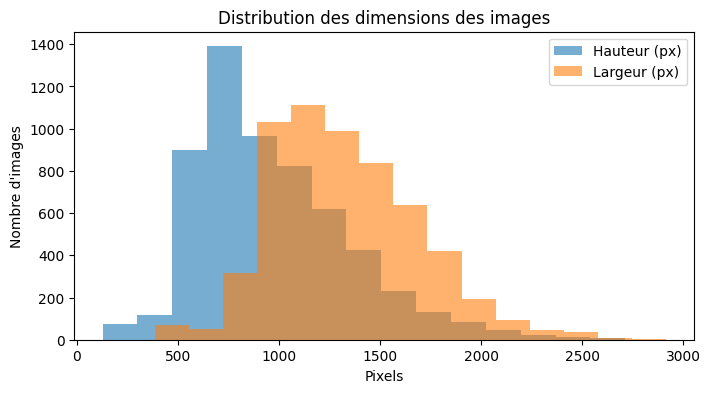

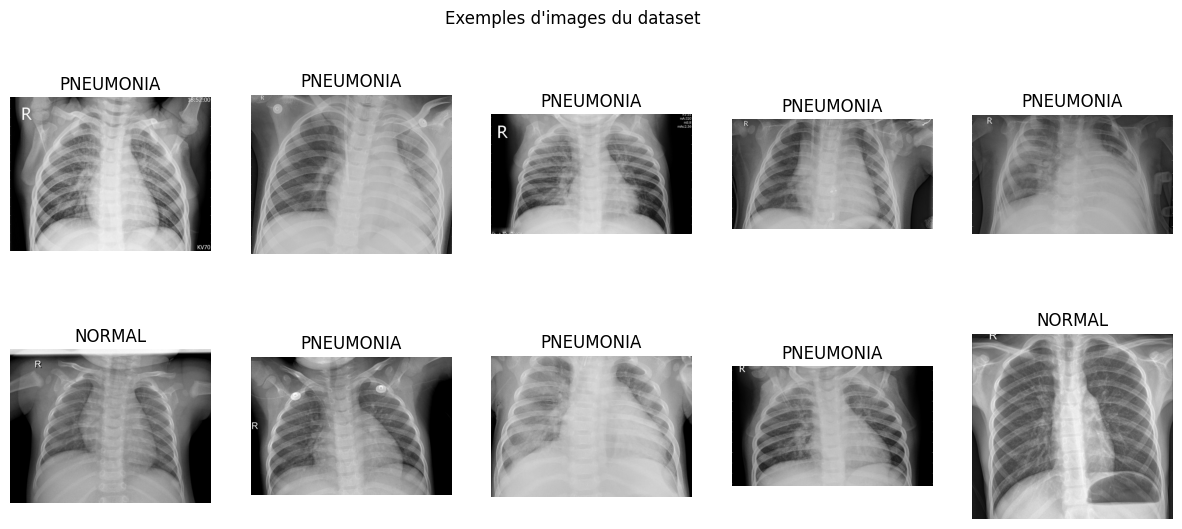

In [12]:

# 1️⃣ Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=df)
plt.title("Distribution des classes : Normal vs Pneumonia")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()

# 2️⃣ Image size/resolution distribution
plt.figure(figsize=(8,4))
plt.hist(df['height'], bins=15, alpha=0.6, label='Hauteur (px)')
plt.hist(df['width'], bins=15, alpha=0.6, label='Largeur (px)')
plt.title("Distribution des dimensions des images")
plt.xlabel("Pixels")
plt.ylabel("Nombre d'images")
plt.legend()
plt.show()

# 3️⃣ Aperçu d'images aléatoires
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for ax in axes.flatten():
    img_path = df.sample(1)["path"].values[0]
    img = io.imread(img_path)
    ax.imshow(img, cmap="gray")
    ax.set_title(img_path.split("/")[-2])  # Shows NORMAL or PNEUMONIA
    ax.axis('off')

plt.suptitle("Exemples d'images du dataset")
plt.show()


Le dataset est déséquilibré, avec beaucoup plus d’images pneumonia que de normal .

Pour la classification, il faudra penser à gérer ce déséquilibre :

* class_weight dans l’entraînement

* ou oversampling / augmentation des images normales

Toutes les images ne sont pas uniformes, donc pas besoin de redimensionnement pour MobileNetV2, mais MobileNetV2 attend 224×224 et 3 canaux, donc il faudra convertir en RGB et resize.

# 2.Prétraitement (mmodèle mobileNet2V)

In [13]:
# ===============================
# Dataset path & classes
# ===============================
import tensorflow as tf

train_dir = "/content/Pediatric Chest X-ray Pneumonia/train"
test_dir  = "/content/Pediatric Chest X-ray Pneumonia/test"

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


In [14]:
#Load Train With Validation Split (stratified)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


Conversion grayscale→RGB si nécessaire (géré par decode_image(..., channels=3)).

Resize → 224×224.

Normalisation MobileNetV2 → pixel ∈ [-1,1].

Vérifier orientation correcte (rarement nécessaire sur CXR).

Sauvegarder logs des images modifiées / supprimées.

In [15]:
#Data Augmentation + Normalization (MobileNetV2 —> [-1,1])
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomTranslation(0.02,0.02),
    tf.keras.layers.RandomContrast(0.08),
])

def preprocess(img, label):
    img = tf.cast(img, tf.float32)
    img = (img / 127.5) - 1.0   # [0,255] -> [-1,1]
    return img, label

def prepare(ds, augment=False):
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, augment=True)
val_ds   = prepare(val_ds,   augment=False)
test_ds  = prepare(test_ds,  augment=False)


In [17]:
normal_count = len(os.listdir(f"{train_dir}/NORMAL"))
pneumonia_count = len(os.listdir(f"{train_dir}/PNEUMONIA"))

total = normal_count + pneumonia_count

class_weight = {
    0: total / (2 * normal_count),
    1: total / (2 * pneumonia_count)
}

print("Class weights:", class_weight)


Class weights: {0: 1.939214232765011, 1: 0.6737058975019315}


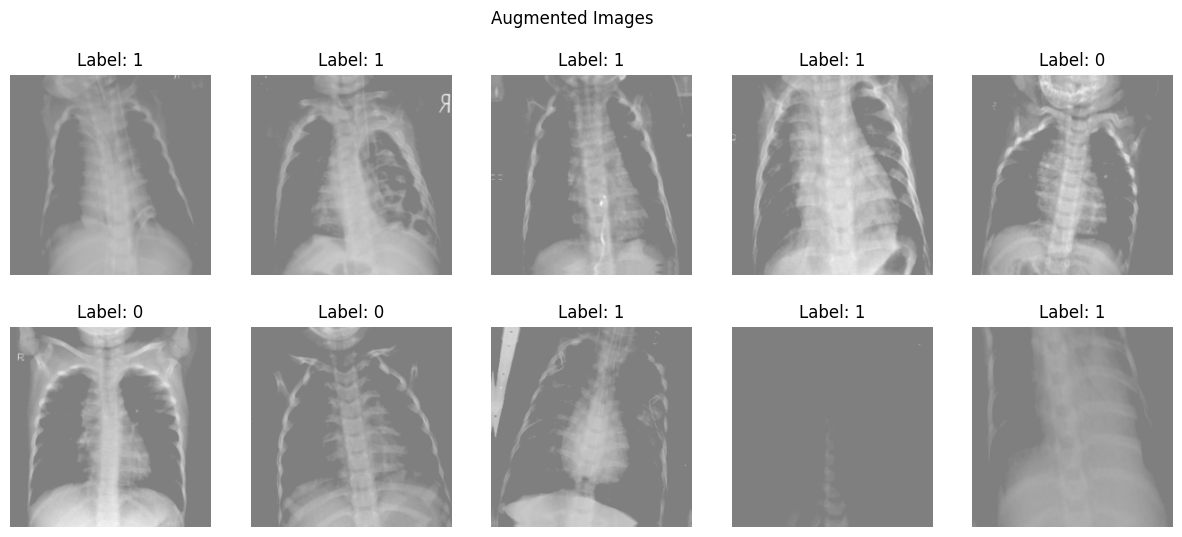

In [18]:
for img_batch, label_batch in train_ds.take(1):
    fig, axes = plt.subplots(2,5, figsize=(15,6))
    for i, ax in enumerate(axes.flatten()):
        img = (img_batch[i].numpy() + 1) / 2  # [-1,1] → [0,1]
        ax.imshow(img)
        ax.set_title(f"Label: {label_batch[i].numpy()}")
        ax.axis("off")
    plt.suptitle("Augmented Images")
    plt.show()


In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [20]:
def create_local_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

local_model = create_local_model()
history = local_model.fit(train_ds, validation_data=val_ds, epochs=10)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 130s 835ms/step - accuracy: 0.7188 - loss: 0.5743 - val_accuracy: 0.7600 - val_loss: 0.5517
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 673ms/step - accuracy: 0.9202 - loss: 0.1987 - val_accuracy: 0.7620 - val_loss: 0.5884
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 637ms/step - accuracy: 0.9445 - loss: 0.1530 - val_accuracy: 0.7696 - val_loss: 0.5237
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 145s 659ms/step - accuracy: 0.9471 - loss: 0.1447 - val_accuracy: 0.7744 - val_loss: 0.5260
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 94s 713ms/step - accuracy: 0.9546 - loss: 0.1239 - val_accuracy: 0.7811 - val_loss: 0.4975
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 643ms/step - accuracy: 0.9577 - loss: 0.1222 - val_accuracy: 0.7983 - val_loss: 0.4245
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 646ms/step - accuracy: 0.9601 - loss: 0.1128 - val_accuracy: 0.7935 - val_loss: 0.4481
Epoch 8/10
131/131 ━━━━━━━━━━━━━

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

y_pred = local_model.predict(test_ds)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)  # Flatten
y_true = np.concatenate([y for x,y in test_ds], axis=0)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step
Accuracy: 0.6602564102564102
Precision: 0.6478405315614618
Recall: 1.0
F1-score: 0.7862903225806451
Confusion Matrix:
 [[ 22 212]
 [  0 390]]


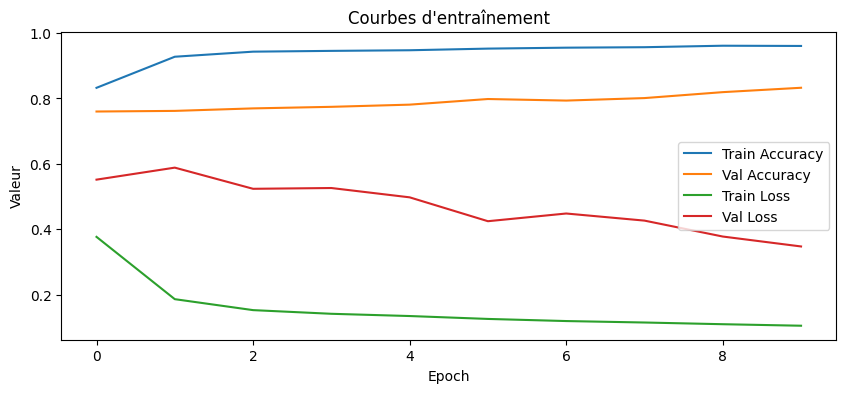

In [23]:
# 3️⃣ Visualisation métriques d'entraînement
# ===============================
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbes d'entraînement")
plt.xlabel("Epoch")
plt.ylabel("Valeur")
plt.legend()
plt.show()

Observation : le modèle converge bien sur les données locales, pas de surapprentissage majeur. Les fluctuations de la validation sont normales pour un dataset de petite taille.

houni

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract labels from TF datasets
train_labels = np.concatenate([y.numpy() for _, y in train_ds])
val_labels   = np.concatenate([y.numpy() for _, y in val_ds])
test_labels  = np.concatenate([y.numpy() for _, y in test_ds])

# Convert to class names
map_names = {0: "Normal", 1: "Pneumonia"}

train_labels = pd.Series(train_labels).map(map_names)
val_labels   = pd.Series(val_labels).map(map_names)
test_labels  = pd.Series(test_labels).map(map_names)


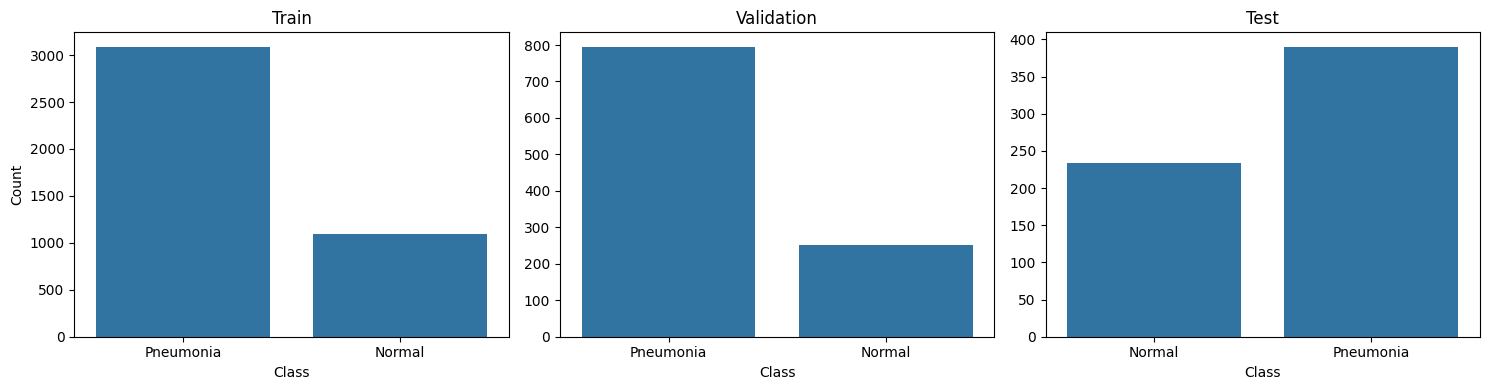

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.countplot(x=train_labels, ax=axes[0])
axes[0].set_title("Train")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(x=val_labels, ax=axes[1])
axes[1].set_title("Validation")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("")

sns.countplot(x=test_labels, ax=axes[2])
axes[2].set_title("Test")
axes[2].set_xlabel("Class")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()


Observation :

* Le modèle détecte bien les images normales.

* Il détecte très mal les cas de tuberculose → problème de déséquilibre de classes.

* Même si l’accuracy globale peut sembler bonne, la performance sur la classe minoritaire est faible.